In this project I want to check how the win percentages for Poland men's national football and volleyball teams have change over the last fifty years and if their performances are different. I will use win/loss ratio (number of wins over the number of wins plus the number of losses.).

I scraped Wikipedia for data concerning wins and losses for each team.

In [1]:
import requests
import pandas as pd
import html5lib
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotx
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
fball_2001_2022 = requests.get("https://pl.wikipedia.org/wiki/Lista_mecz%C3%B3w_reprezentacji_Polski_w_pi%C5%82ce_no%C5%BCnej_m%C4%99%C5%BCczyzn_(od_2001)#Lata_2021%E2%80%932030")
football_2001_2022 = pd.read_html(fball_2001_2022.text)

#football_2001_2022[2] = football_2001_2022[2][football_2001_2022[2]["Wynik[1]"].notna()]

for i in range(3):
    # leaving columns of interest and renaming them
    football_2001_2022[i] = football_2001_2022[i].loc[:, ["Gospodarz", "Gość", "Wynik[1]"]]
    football_2001_2022[i].rename(columns={"Gospodarz":"Host", "Gość":"Guest", "Wynik[1]":"Score"}, inplace=True)

    # dropping MultiIndex levels
    if i != 0:
        football_2001_2022[i].columns = football_2001_2022[i].columns.droplevel(1)

    # adding "Year" column, based on rows filled with years
    football_2001_2022[i]["Year"] = football_2001_2022[i]["Host"].apply(lambda x: x if x.isnumeric() else np.nan)
    football_2001_2022[i]["Year"].ffill(inplace=True)

# filling missing years
football_2001_2022[1]["Year"].fillna(2011, inplace=True)
football_2001_2022[2]["Year"].fillna(2021, inplace=True)

# dropping future matches (unknown scores)
football_2001_2022[2] = football_2001_2022[2][football_2001_2022[2]["Score"].notna()]

football_2001_2022[2].head()

,Host,Guest,Score,Year
0,Węgry,Polska,3:3 (1:0),2021
1,Polska,Andora,3:0 (1:0),2021
2,Anglia,Polska,2:1 (1:0),2021
3,Polska,Rosja,1:1 (1:1),2021
4,Polska,Islandia,2:2 (1:1),2021


In [3]:
fball_1972_2000 = requests.get("https://pl.wikipedia.org/wiki/Lista_mecz%C3%B3w_reprezentacji_Polski_w_pi%C5%82ce_no%C5%BCnej_m%C4%99%C5%BCczyzn_(1921%E2%80%932000)")
football_1972_2000 = pd.read_html(fball_1972_2000.text)

football_1972_2000[5] = football_1972_2000[5].loc[10:]

for i in range(5,8):
    # leaving columns of interest and renaming them
    football_1972_2000[i] = football_1972_2000[i].loc[:, ["Gospodarz", "Gość", "Wynik[1]"]]
    football_1972_2000[i].rename(columns={"Gospodarz":"Host", "Gość":"Guest", "Wynik[1]":"Score"}, inplace=True)

    # adding "Year" column, based on rows filled with years
    football_1972_2000[i]["Year"] = football_1972_2000[i]["Host"].apply(lambda x: x if x.isnumeric() else np.nan)
    football_1972_2000[i]["Year"].ffill(inplace=True)

football_1972_2000[5]


,Host,Guest,Score,Year
10,1972,1972,1972,1972
11,Polska,NRD,2:1 (1:0),1972
12,Bułgaria,Polska,3:1 (0:1),1972
13,Polska,Hiszpania am.,2:0 (1:0),1972
14,Polska,Bułgaria,3:0 (1:0),1972
...,...,...,...,...
139,Polska,Czechosłowacja,1:1 (1:1),1980
140,Argentyna,Polska,2:1 (1:0),1980
141,Hiszpania,Polska,1:2 (0:1),1980
142,Polska,Algieria,5:1 (3:0),1980


In [4]:
football = pd.concat([football_1972_2000[5],football_1972_2000[6],football_1972_2000[7],football_2001_2022[0],football_2001_2022[1],football_2001_2022[2]])
football = football[football["Host"].str.isalpha()]

# extracting separate scores for hosts and guests
football[["Host Score", "Guest Score"]]=football["Score"].str.extract("(\d):(\d)")

# getting rid of ties
football = football[football["Host Score"]!=football["Guest Score"]]
football.reset_index(inplace=True)

# checking when Poland won
football["Host Win"]=football["Host Score"]>football["Guest Score"]
football["Win"] = football[football["Host"]=="Polska"]["Host Win"].apply(lambda x: 1 if x==True else 0)
football.loc[(football["Host"]!="Polska")&(football["Host Win"]==True),"Win"] = 0
football["Win"].fillna(1, inplace=True)

# counting won and lost matches for each year
football = football[["Win", "Year"]].groupby(["Year", "Win"]).agg(len).reset_index()
football["Year"]=football["Year"].astype(int)
football.sort_values(by=["Year", "Win"])
football["Lost"] = football[football["Win"]==0].loc[:,0]
football["Lost"].ffill(inplace=True)
football = football[football["Win"]==1]

# counting win/loss ratio (as number of wins over the number of wins plus the number of losses)
football["Win/loss ratio"] = football[0]/(football[0]+football["Lost"])
football=football.loc[:,["Year", "Win/loss ratio"]]
football.set_index("Year", inplace=True)
football = football.sort_index()
football.head()

,Win/loss ratio
Year,
1972,0.909091
1973,0.800000
1974,0.733333
1975,0.857143
1976,0.500000


In [5]:
vball_1972_1999 = requests.get("https://pl.wikipedia.org/wiki/Mecze_reprezentacji_Polski_w_pi%C5%82ce_siatkowej_m%C4%99%C5%BCczyzn_(1948%E2%80%931999)")
volleyball_1972_1999 = pd.read_html(vball_1972_1999.text, index_col=0)

volleyball_1972_1999[2] = volleyball_1972_1999[2].loc[1972:]

for i in range(2,5):
    # dropping MultiIndex levels
    volleyball_1972_1999[i].columns = volleyball_1972_1999[i].columns.droplevel(1)

    # adding "Year" column, based on rows filled with years
    volleyball_1972_1999[i]["Year"] = volleyball_1972_1999[i]["Przeciwnik"].apply(lambda x: x if x.isnumeric() else np.nan)
    volleyball_1972_1999[i]["Year"].ffill(inplace=True)

    # leaving columns of interest and renaming them
    volleyball_1972_1999[i] = volleyball_1972_1999[i][["Wynik (Polska-przeciwnik)", "Year"]]
    volleyball_1972_1999[i].rename(columns={"Wynik (Polska-przeciwnik)":"Score (Poland-opponent)"}, inplace=True)

# filling missing years
volleyball_1972_1999[3]["Year"].fillna(1980, inplace=True)
volleyball_1972_1999[4]["Year"].fillna(1990, inplace=True)

volleyball_1972_1999[2].head()



Nr,Score (Poland-opponent),Year
1972,1972,1972
489,"3:0 (16:14, 15:6, 15:4)",1972
490,"3:1 (15:2, 11:15, 15:11, 15:13)",1972
491,"3:0 (15:12, 15:2, 15:12)",1972
492,"3:2 (15:4, 11:15, 15:11, 11:15, 15:11)",1972


In [6]:
vball_2000_2009 = requests.get("https://pl.wikipedia.org/wiki/Mecze_reprezentacji_Polski_w_pi%C5%82ce_siatkowej_m%C4%99%C5%BCczyzn_(2000%E2%80%932009)")
volleyball_2000_2009 = pd.read_html(vball_2000_2009.text, index_col=0)
volleyball_2000_2009[0] #0

# dropping MultiIndex levels
volleyball_2000_2009[0].columns = volleyball_2000_2009[0].columns.droplevel(1)

# adding "Year" column, based on rows filled with years
volleyball_2000_2009[0]["Year"] = volleyball_2000_2009[0]["Przeciwnik"].apply(lambda x: x if x.isnumeric() else np.nan)
volleyball_2000_2009[0]["Year"].ffill(inplace=True)
volleyball_2000_2009[0]["Year"].fillna(2000, inplace=True)

# leaving columns of interest and renaming them
volleyball_2000_2009[0] = volleyball_2000_2009[0][["Wynik (Polska-przeciwnik)", "Year"]]
volleyball_2000_2009[0].rename(columns={"Wynik (Polska-przeciwnik)":"Score (Poland-opponent)"}, inplace=True)

volleyball_2000_2009[0].head()


Nr,Score (Poland-opponent),Year
1436,"3:2 (23:25, 25:19, 29:31, 25:18, 15:11)",2000
1437,"1:3 (25:23, 21:25, 20:25, 32:34)",2000
1438,"3:1 (25:19, 25:20, 20:25, 25:19)",2000
1439,"3:1 (18:25, 25:19, 25:20, 25:18)",2000
1440,"1:3 (19:25, 20:25, 25:18, 25:27)",2000


In [7]:
vball_2010_2022 = requests.get("https://pl.wikipedia.org/wiki/Mecze_reprezentacji_Polski_w_pi%C5%82ce_siatkowej_m%C4%99%C5%BCczyzn")
# volleyball_2010_2022 = pd.read_html(vball_2010_2022.text[:224872]+vball_2010_2022.text[224873:1000000], index_col=0)

volleyball_2010_2022 = pd.read_html(vball_2010_2022.text[:224851]+vball_2010_2022.text[224852:1000000], index_col=0)

for i in range(2):
    # dropping MultiIndex levels
    volleyball_2010_2022[i].columns = volleyball_2010_2022[i].columns.droplevel(1)

    # adding "Year" column, based on rows filled with years
    volleyball_2010_2022[i]["Year"] = volleyball_2010_2022[i]["Przeciwnik"].apply(lambda x: x if x.isnumeric() else np.nan)
    volleyball_2010_2022[i]["Year"].ffill(inplace=True)

    # leaving columns of interest and renaming them
    volleyball_2010_2022[i] = volleyball_2010_2022[i][["Wynik (Polska-przeciwnik)", "Year"]]
    volleyball_2010_2022[i].rename(columns={"Wynik (Polska-przeciwnik)":"Score (Poland-opponent)"}, inplace=True)

# filling missing years
volleyball_2010_2022[0]["Year"].fillna(2010, inplace=True)
volleyball_2010_2022[1]["Year"].fillna(2020, inplace=True)

volleyball_2010_2022[1].head()


Nr,Score (Poland-opponent),Year
2161,"3:2 (18:25, 23:25, 25:17, 25:22, 15:10)",2020
2162,"3:1 (26:24, 25:16, 25:21, 25:27)",2020
2021,2021,2021
2163,"4:0 (25:13, 25:14, 25:14, 25:17)",2021
2164,"4:0 (25:14, 25:21, 25:11, 25:20)",2021


In [8]:
volleyball = pd.concat([volleyball_1972_1999[2],volleyball_1972_1999[3],volleyball_1972_1999[4],volleyball_2000_2009[0],volleyball_2010_2022[0],volleyball_2010_2022[1]])
volleyball = volleyball[volleyball["Score (Poland-opponent)"].str.contains(":")]

# extracting separate scores for hosts and guests
volleyball[["Poland's Score", "Opponent's Score"]]=volleyball["Score (Poland-opponent)"].str.extract("(\d):(\d)")

# getting rid of ties
volleyball = volleyball[volleyball["Poland's Score"]!=volleyball["Opponent's Score"]]
volleyball.reset_index(inplace=True)

# checking when Poland won
volleyball["Poland's Win"]=volleyball["Poland's Score"]>volleyball["Opponent's Score"]
volleyball["Win"] = volleyball["Poland's Win"].apply(lambda x: 1 if x==True else 0)

# counting won and lost matches for each year
volleyball = volleyball[["Win", "Year"]].groupby(["Year", "Win"]).agg(len).reset_index()
volleyball["Year"]=volleyball["Year"].astype(int)
volleyball.sort_values(by=["Year", "Win"])
volleyball["Lost"] = volleyball[volleyball["Win"]==0].loc[:,0]
volleyball["Lost"].ffill(inplace=True)
volleyball = volleyball[volleyball["Win"]==1]

# counting win/loss ratio (as number of wins over the number of wins plus the number of losses)
volleyball["Win/loss ratio"] = volleyball[0]/(volleyball[0]+volleyball["Lost"])
volleyball=volleyball.loc[:,["Year", "Win/loss ratio"]]
volleyball.set_index("Year", inplace=True)
volleyball = volleyball.sort_index()
volleyball.head()

,Win/loss ratio
Year,
1972,0.642857
1973,0.869565
1974,0.891892
1975,0.888889
1976,0.851852


In [13]:
volleyball.describe()

,Win/loss ratio
count,51.000000
mean,0.645095
std,0.149725
min,0.117647
25%,0.558442
50%,0.647059
75%,0.729167
max,0.891892


In [15]:
football.describe()

,Win/loss ratio
count,51.000000
mean,0.612057
std,0.176099
min,0.222222
25%,0.500000
50%,0.600000
75%,0.750000
max,0.909091


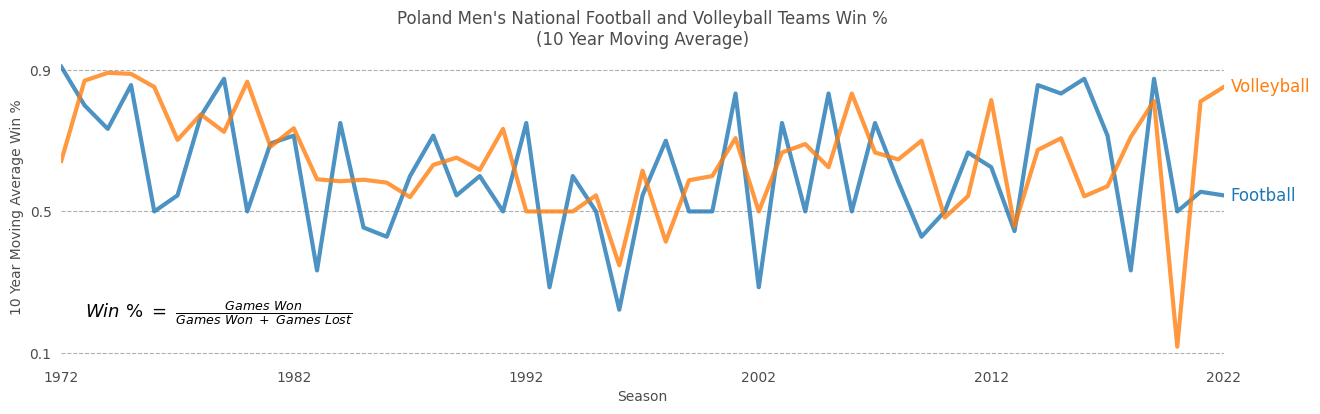

In [20]:
plt.figure(figsize=(15,4))
plt.title("Poland Men's National Football and Volleyball Teams Win %\n(10 Year Moving Average)", alpha=0.7)
plt.xlabel("Season", alpha=0.7)
plt.ylabel("10 Year Moving Average Win %", alpha=0.7)
ax = plt.gca()

plt.plot(football, linewidth=3, label="Football", alpha=0.8)
plt.plot(volleyball, linewidth=3, label="Volleyball", alpha=0.8)
plt.yticks([0.1,0.5,0.9], alpha=0.7)
plt.xticks([1972, 1982,1992,2002,2012,2022], alpha=0.7)

plt.xlim([1972,2022])

def improve_legend(ax=None):
    if ax is None:
        ax = plt.gca()

    # Hide spines
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)

    # line labels to the right    
    for line in ax.lines:
        data_x, data_y = line.get_data()
        right_most_x = data_x[-1]
        right_most_y = data_y[-1]
        ax.annotate(
            line.get_label(),
            xy=(right_most_x, right_most_y),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            color=line.get_color(),
            fontsize=12
        )
    ax.legend().set_visible(False)
improve_legend(ax)

# dashed grid
plt.grid(axis ='y', linestyle='dashed')

ax.tick_params(bottom=False, left=False)

# annotation about Win %
plt.annotate(text=r'$Win\ \%\ =\ \frac{Games\ Won}{Games\ Won\ +\ Games\ Lost}$', xy=(1973,0.2), fontsize=13);


This visualization was concerned with answering the question of how the win percentages of Poland men's national football and volleyball teams have change over the last fifty years and if their performances are different. Any tie games were dropped from the analysis in order to provide a more level comparison between the sports. A 10 year moving average was plotted to help the reader identify any major trends in the team’s win percentages.

The plot indicates high variation for both teams, with no meaningful difference in their performances and means hovering slightly above 50%.